In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pyplot
import numpy as np,matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

In [56]:
! pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [58]:
! kaggle datasets download rupakroy/online-payments-fraud-detection-dataset

online-payments-fraud-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [59]:
! unzip online-payments-fraud-detection-dataset

Archive:  online-payments-fraud-detection-dataset.zip
replace PS_20174392719_1491204439457_log.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: PS_20174392719_1491204439457_log.csv  





In [60]:
data = pd.read_csv("PS_20174392719_1491204439457_log.csv")

In [61]:
# |data=data_huge.sample(n=50000)
data = data.drop(["nameDest", "nameOrig"] , axis = 1).sample(10000)
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5286759,373,CASH_OUT,358762.86,434.00,0.00,313247.36,672010.22,0,0
4400123,321,CASH_IN,223307.57,42458.00,265765.57,0.00,0.00,0,0
5691967,397,CASH_OUT,22290.35,50394.00,28103.65,349900.70,372191.06,0,0
3067701,235,CASH_OUT,36851.60,6408.00,0.00,0.00,36851.60,0,0
4107903,302,CASH_IN,123752.79,10097360.54,10221113.32,1564141.69,1440388.90,0,0


In [62]:
data.shape

(10000, 9)

In [63]:
data = pd.concat([data, pd.get_dummies(data['type'],drop_first=True)] , axis = 1).drop(["type"], axis = 1)
data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
5286759,373,358762.86,434.00,0.00,313247.36,672010.22,0,0,1,0,0,0
4400123,321,223307.57,42458.00,265765.57,0.00,0.00,0,0,0,0,0,0
5691967,397,22290.35,50394.00,28103.65,349900.70,372191.06,0,0,1,0,0,0
3067701,235,36851.60,6408.00,0.00,0.00,36851.60,0,0,1,0,0,0
4107903,302,123752.79,10097360.54,10221113.32,1564141.69,1440388.90,0,0,0,0,0,0


In [64]:
scaler = StandardScaler()
scaler.fit(data.drop('isFraud',axis=1))
scaled_data = scaler.transform(data.drop('isFraud',axis=1))

In [65]:
# x, x_test, y, y_test = train_test_split(x_data,y_data,test_size=0.2,train_size=0.8)
x_train, x_test, y_train, y_test = train_test_split(scaled_data,data['isFraud'],test_size=0.2,train_size=0.8)
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
validation_scores = {}
for degree in range(1,7,1):
  PolyDegree = PolynomialFeatures(degree= degree, include_bias = False, interaction_only = True)
  data_new= PolyDegree.fit_transform(x_train)
  model= LogisticRegression(penalty = "none", max_iter=10000)
  validation_score = cross_val_score(model,data_new,y_train, cv=skf, scoring = 'f1').mean()
  validation_scores[degree] = validation_score


In [66]:
print(validation_scores)

# Degree 1 Achieves best F1 Score

{1: 0.8095238095238095, 2: 0.4253968253968254, 3: 0.2361111111111111, 4: 0.2708333333333333, 5: 0.2039072039072039, 6: 0.2912087912087912}


In [67]:
PolyDegree = PolynomialFeatures(degree= 1, include_bias = False, interaction_only = True)
data_new= PolyDegree.fit_transform(x_train)
x_test_transformed = PolyDegree.fit_transform(x_test)
model= LogisticRegression(penalty = "none", max_iter=10000)
model.fit(data_new, y_train)

print(f"Model Accuracy = {model.score(x_test_transformed, y_test)*100}%")


Model Accuracy = 99.8%


In [73]:
validation_score_reg = []
for lambdda in np.arange(0.0, 20, step=0.1):
  Reg_model= LogisticRegression(penalty = "l2", max_iter=5000, C = 1/lambdda)
  validation_score = cross_val_score(model,data_new,y_train, cv=skf, scoring = 'f1').mean()
  validation_score_reg.append(validation_score)
  # training_score_reg[lambdda] = mean_squared_error(y_train, Reg_model.predict(data_new))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


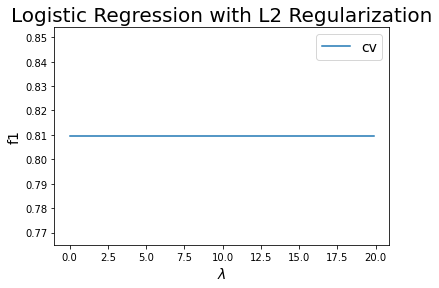

In [74]:
plt.plot(np.arange(0.0, 20, step=0.1), validation_score_reg, label="cv")
    # plt.plot(lambdas, test_errors, label="cv")
plt.xlabel("$\\lambda$", fontsize=14)
plt.ylabel("f1", fontsize=14)
plt.title("Logistic Regression with L2 Regularization", fontsize=20)
plt.legend(fontsize=14)
plt.show()